<a href="https://colab.research.google.com/github/JerryKurata/colab-pytorch/blob/master/Fashion_MNIST_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion-MNIST in Pytorch 

This notebook demonstrates how we can implement Fashion-MNIST in Pytorch.  This implementation illustrates how we use:


*   torch
*   torch.nn - Neural Network
*   torch.optim - Optimizers
*   torchvision - Neural Netwoks for Computer Vision

*This code is largely based on this tutorial:https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html* and the code in https://github.com/pytorch/examples/blob/master/mnist/main.py

In [0]:
# Imports

# pyplot is plotting.  numpy is our best friend
import matplotlib.pyplot as plt
import numpy as np

# torch is general torch, torchvision is vision NN layers and utilities
#   .transforms is routine that transform vision data
import torch
import torchvision
import torchvision.transforms as transforms

# We are going to use torch NN libraries, functional API (keras-like), and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [0]:
# Parameters
num_epochs = 25
batch_size = 100
learning_rate = 0.001


## Load the Data

We first need to load the data.  We could do this from files.  But **torchvision** has a dataset class that supports loading of data for specific well-know models like Fashion-MNIST. And by using this dataset library we do not have to update this code if the data location changes.

Notice that we set the batch size in the DataLoader

In [0]:
# Define transform with to tensor and normalizer.  We normalize each channel
#  values to -1.0 to 1.0 via image = (image - mean)/std.  
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
# Download and transform the Fashion-MNIST training and testing datasets
train_data = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,    # true for training data
    transform=transform)
test_data = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,   # false for test data
    transform=transform)

# Define Loaders for training and evaluating with the training and test datasets
#  num_workers = 2 runs 2 subprocesses to speed the loading
train_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                           shuffle=False, num_workers=2)


TypeError: ignored

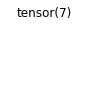

In [26]:
# Define class label names for displaying.  Class labels are [0,1,2,...,9] and these
#  labels are match class to position.  So class=0 => 'T-shirt/top', class=1 => 'Trousers'
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def imshow(img):
  np_img = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

imshow(torchvision.utils.make_grid(images))


# Define a helper function to show the image
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:   # do we want grayscale?
        plt.imshow(npimg, cmap="Greys")
    else:             # rgb
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

#Display the images from the traning data
plt.figure(figsize=(12, 8))
for i in range (batch[0].shape[0]):
    plt.subplot(1, 4, i+1)
    plt.axis('off')
    plt.imshow(batch[0][i].reshape(28, 28), cmap='gray')
    plt.title(int(batch[1][i]))
    plt.savefig('digit_mnist.png')
plt.show()

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, one_chan cmap='gray')
plt.show()

## Define the Model

We define our model here.  Feel free to experiment with the model structure.  Even a linear model of 2 layers will work with the MNIST data.  But, it probably will not perform that well.  But give it a try!! 

Notice the forward() method connects each layer to the next.  Read up on nn.Sequeunce and see if that works.  For Keras
users, nn.Sequence is like the Keras Sequential modeand this code is like the Keras API.

In [0]:
#  Define NN Model class
class Model(nn.Module):

  # Define the storage for the weights
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

  # Hook up the foward pass
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create instance of NN Model
model = Model()



When we train we use the loss criterion to measure loss, and the optimizer method to reduce loss.

Our items are one of the 10 classes of fashion items.  CrossEntropyLoss shows how poorly our model is doing at predicting each of the classes.

The optimizer will adjust parameters (weights) in the model to minimuze this loss.

In [0]:
# Define loss criterion and optimizer method
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

##  Train the model 

We calculate a loss for each epoch

In [19]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    num_items = 0
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_items += 1
        
    print('Train Epoch: {}   Loss: {:.6f}'.format(
                epoch, running_loss/num_items ))        

print('Finished Training')

Train Epoch: 0   Loss: 2.203316
Train Epoch: 1   Loss: 0.922050
Train Epoch: 2   Loss: 0.691508
Train Epoch: 3   Loss: 0.632041
Train Epoch: 4   Loss: 0.587824
Train Epoch: 5   Loss: 0.546444
Train Epoch: 6   Loss: 0.514885
Train Epoch: 7   Loss: 0.486205
Train Epoch: 8   Loss: 0.468119
Train Epoch: 9   Loss: 0.444236
Train Epoch: 10   Loss: 0.429095
Train Epoch: 11   Loss: 0.413020
Train Epoch: 12   Loss: 0.399607
Train Epoch: 13   Loss: 0.391053
Train Epoch: 14   Loss: 0.379671
Train Epoch: 15   Loss: 0.370222
Train Epoch: 16   Loss: 0.363817
Train Epoch: 17   Loss: 0.357661
Train Epoch: 18   Loss: 0.350080
Train Epoch: 19   Loss: 0.346251
Train Epoch: 20   Loss: 0.337668
Train Epoch: 21   Loss: 0.334007
Train Epoch: 22   Loss: 0.330064
Train Epoch: 23   Loss: 0.322001
Train Epoch: 24   Loss: 0.319290
Finished Training


## Evaluate the trained model's performance on Testing Data

Of course, once we have the model trained, we want to evaluate it's performance. That is why separate training from testing/evaluation data.  And we never train with the testing/evaluation data.

So now we will use this testing/evaluation data to see how well our trained model does on data it was **not** trained on.

Notice we first use model.eval().  This will model.eval() will notify all layers that you are in eval mode, and that way, batchnorm or dropout layers will work in eval mode instead of training mode.  (https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615)

In [0]:
# Evaluate trained model's performance on Testing data
  model.eval()          # Set model to evaluation mode
  test_loss = 0
  correct = 0
  with torch.no_grad(): # Turn off gradient computation
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



Test set: Average loss: -10.3337, Accuracy: 8746/10000 (87%)



## Things to try

*   Adjust batch_size and other parameters
*   Alter the model with different layers and/or layer parameters 
*   Add support for GPU
*   Replace model definition with nn.Sequential() 

